In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\david\anaconda3\envs\Dsci\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 45)

In [3]:
ptax_frame = pd.read_excel('data/ON_Ptax/VIEWFIR2021-22.xlsx', skiprows=4)

In [4]:
ptax_frame.head(2)

,Unnamed: 0,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LT/ST\nTax Rate,UT\nTax Rate,EDUC\nTax Rate,TOTAL\nTax Rate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update
0,10_LT,2021,1134,Addington Highlands Tp,57611,11033,57,LT,12,10,0,Addington Highlands Tp,RT,0,Residential,Full Occupied,1.0,1.0,494713900.0,494713900.0,0.006078,0.004973,0.00153,0.012582,3007109,2460281,756912,6224302,2022-08-29
1,50_LT,2021,1134,Addington Highlands Tp,57611,11033,57,LT,12,50,0,Addington Highlands Tp,MT,0,Multi-Residential,Full Occupied,2.0,1.0,1377000.0,1377000.0,0.012157,0.009946,0.00153,0.023633,16740,13696,2107,32543,2022-08-29


In [5]:
ptax_frame[ptax_frame['Municipality'] == 'Pickering C']

,Unnamed: 0,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LT/ST\nTax Rate,UT\nTax Rate,EDUC\nTax Rate,TOTAL\nTax Rate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update


In [6]:
ptax_frame.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
ptax_frame.columns

Index(['Year', 'Asmt Code', 'Municipality', 'MAH Code', 'MunID', 'UT', 'Tier',
       'MSO', 'Line', 'Levy Area', '22 Levy Area Name', 'RTC/RTQ', 'Tax\nBand',
       'Property Class', 'Tax Rate Description', 'Tax Ratio', '% Full Rate',
       'CVA Assessment', 'Phase-In Taxable Assessment', 'LT/ST\nTax Rate',
       'UT\nTax Rate', 'EDUC\nTax Rate', 'TOTAL\nTax Rate', 'LT/ST\nTaxes',
       'UT\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes', 'Last Update'],
      dtype='object')

In [8]:
ptax_frame.rename(columns={'LT/ST\nTax Rate':'LtSt_TaxRate', 'UT\nTax Rate':'Ut_Rate', 'EDUC\nTax Rate':'Education_Rate', 'TOTAL\nTax Rate':'Total_TaxRate'}, inplace=True)

In [9]:
Durham = ['Durham R','Ajax T', 'Clarington M', 'Brock Tp', 'Oshawa C', 'Pickering C', 'Scugog Tp', 'Uxbridge Tp', 'Whitby T']
Halton = ['Halton R', 'Burlington C', 'Halton Hills T', 'Milton T', 'Oakville T']
Peel = ['Peel R', 'Brampton C', 'Mississauga C', 'Caledon T']
York = ['York R', 'Vaughan C', 'Markham C', 'Richmond Hill C', 'Aurora T', 'Newmarket T', 'Whitchurch - Stouffville T', 'East Gwillimbury T', 'Georgina T', 'King Tp']
Dufferin = ['Mono T', 'Orangeville T']
Simcoe = ['Bradford West Gwillimbury T', 'New Tecumseth T']
Toronto = ['Toronto C']

In [10]:
GTA = Durham + Halton + Peel + York + Dufferin + Simcoe + Toronto

In [11]:
len(GTA)

33

In [12]:
gta_ptax_frame = ptax_frame[ptax_frame['Municipality'].isin(GTA)]

In [13]:
gta_ptax_frame.shape

(1025, 28)

In [14]:
gta_ptax_frame['Property Class'].value_counts()

Industrial                 190
Commercial                 177
Commercial, NConstr.        79
Residential                 69
Shopp. Centre, NConstr.     58
Shopping Centre             58
Large Industrial            58
Industrial, NConstr.        53
Office Building             51
Multi-Residential           36
Pipeline                    33
Farmland                    33
Parking Lot                 31
Office Build., NConstr.     31
Managed Forest              29
Large Ind., NConstr.        26
New Multi-Residential       11
Large Theatre                1
Prof. Sports Facility        1
Name: Property Class, dtype: int64

In [15]:
pclasses = ['Residential', 'Commercial', 'Industrial', 'Large Industrial', 'Multi-Residential', 'Farmland', 'Managed Forest', 'Pipeline']

In [16]:
gta_ptax_frame.head(1)

,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LtSt_TaxRate,Ut_Rate,Education_Rate,Total_TaxRate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update
55,2021,1805,Ajax T,10401,18005,10,LT,11,10,0,Ajax T,RT,0,Residential,Full Occupied,1.0,1.0,1.773831e+10,1.773831e+10,0.003414,0.005013,0.00153,0.009957,60558780,88919151,27139620,176617551,2022-09-01


In [17]:
gta_ptax_frame = gta_ptax_frame[(gta_ptax_frame['Property Class'].isin(pclasses)) & (gta_ptax_frame['Tax Rate Description'] == 'Full Occupied')].copy()

In [18]:
gta_ptax_frame.head()

,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LtSt_TaxRate,Ut_Rate,Education_Rate,Total_TaxRate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update
55,2021,1805,Ajax T,10401,18005,10,LT,11,10,0,Ajax T,RT,0,Residential,Full Occupied,1.0000,1.0,1.773831e+10,1.773831e+10,0.003414,0.005013,0.001530,0.009957,60558780,88919151,27139620,176617551,2022-09-01
56,2021,1805,Ajax T,10401,18005,10,LT,11,50,0,Ajax T,MT,0,Multi-Residential,Full Occupied,1.8665,1.0,5.028436e+08,5.028436e+08,0.006372,0.009356,0.001530,0.017259,3204245,4704831,769351,8678427,2022-09-01
57,2021,1805,Ajax T,10401,18005,10,LT,11,110,0,Ajax T,FT,0,Farmland,Full Occupied,0.2000,1.0,2.776680e+07,2.776680e+07,0.000683,0.001003,0.000382,0.002068,18959,27838,10621,57418,2022-09-01
58,2021,1805,Ajax T,10401,18005,10,LT,11,210,0,Ajax T,CT,0,Commercial,Full Occupied,1.4500,1.0,9.720312e+08,9.720312e+08,0.004950,0.007269,0.008800,0.021019,4811856,7065306,8553874,20431036,2022-09-01
66,2021,1805,Ajax T,10401,18005,10,LT,11,510,0,Ajax T,IT,0,Industrial,Full Occupied,2.0235,1.0,1.330657e+08,1.330657e+08,0.006908,0.010143,0.008800,0.025852,919251,1349747,1170978,3439976,2022-09-01


In [19]:
upper_tier = ['York R', 'Halton R', 'Peel R', 'Durham R']

In [20]:
gta_sL_ptax= gta_ptax_frame[~gta_ptax_frame.Municipality.isin(upper_tier)]
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Durham),['Region']] = 'Durham R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(York),['Region']] = 'York R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Peel),['Region']] = 'Peel R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Halton),['Region']] = 'Halton R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Dufferin),['Region']] = 'Dufferin Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Simcoe),['Region']] = 'Simcoe Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Toronto),['Region']] = 'Toronto C'

In [58]:
palette = {
    'Toronto C': 'dodgerblue',
    'York R': 'firebrick',
    'Halton R': 'limegreen',
    'Peel R':'indigo',
    'Durham R': 'gold',
    'Simcoe Co': 'turquoise',
    'Dufferin Co':'violet'
}

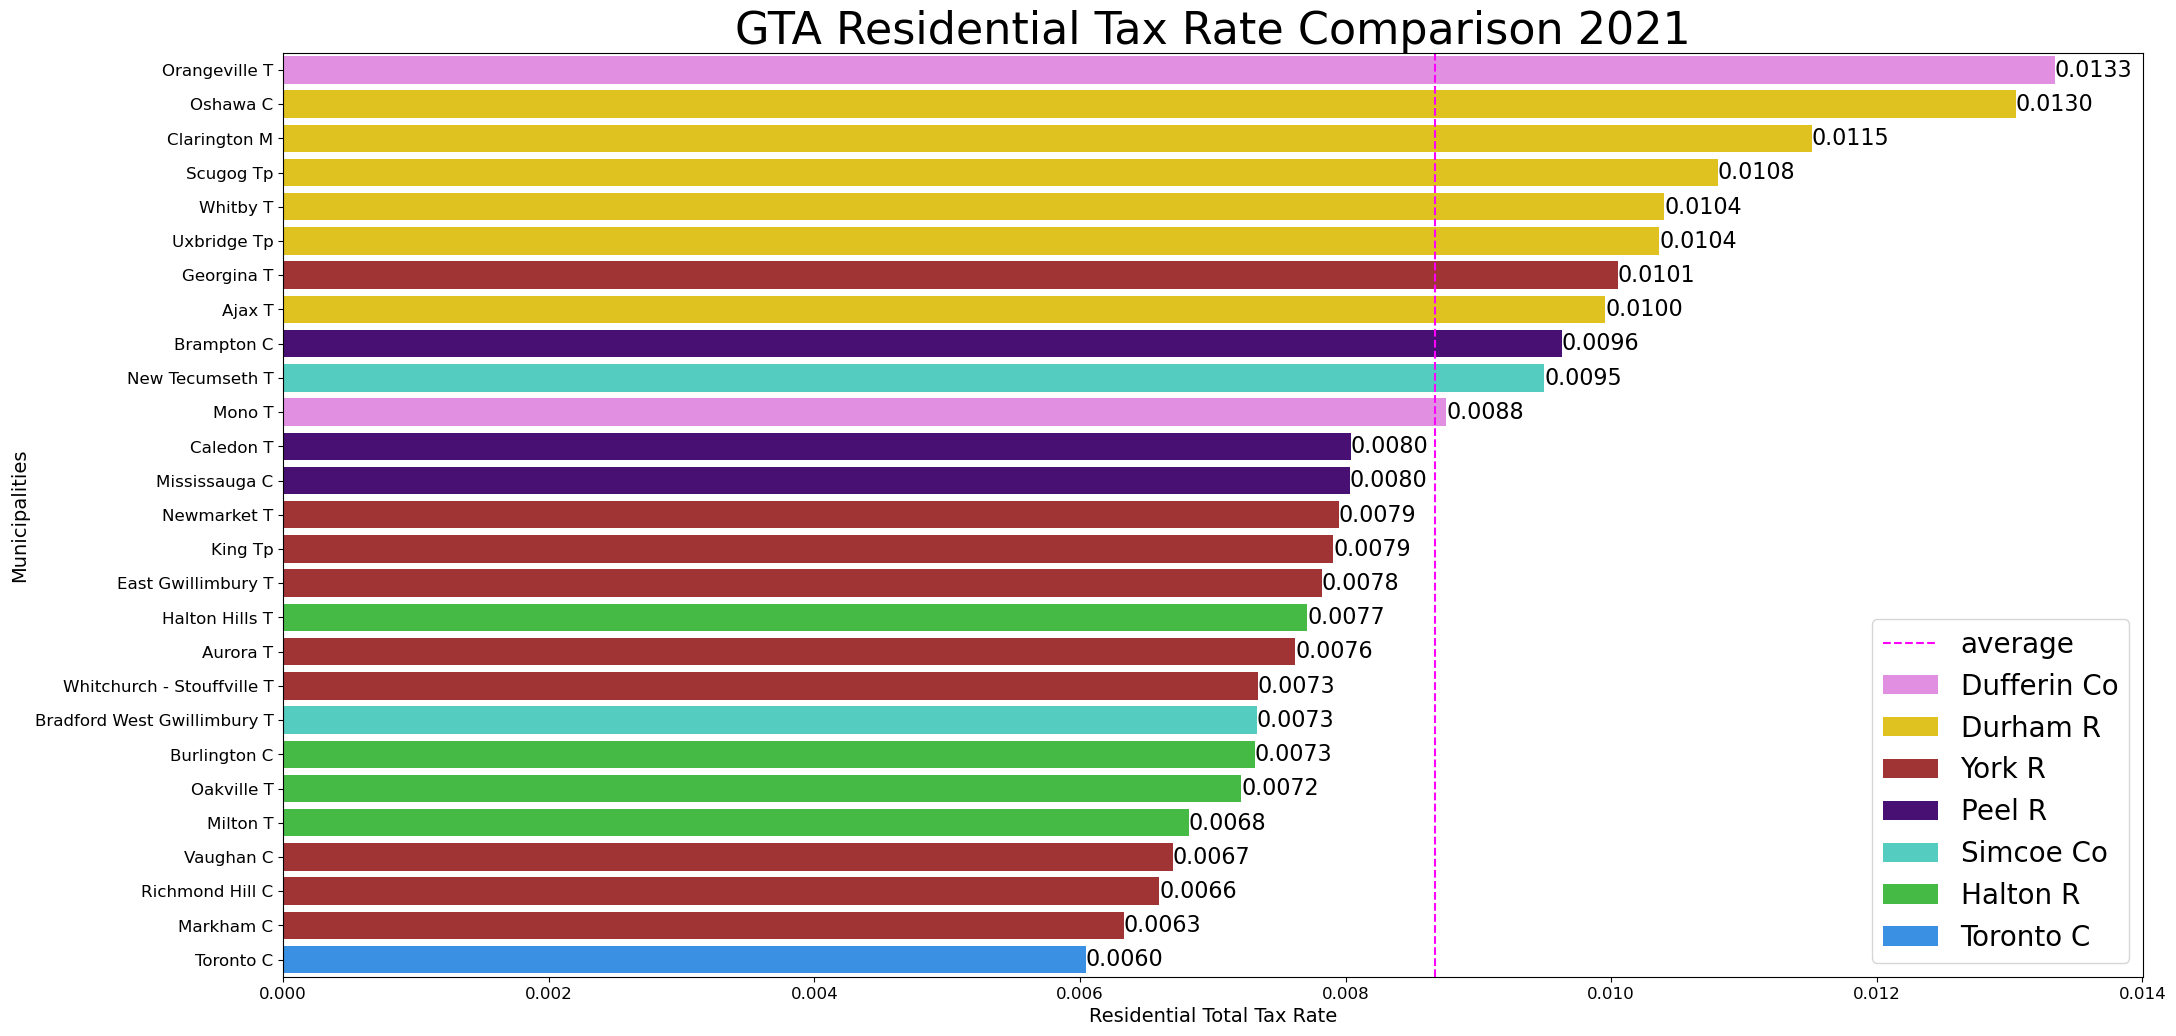

In [59]:
data=gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Residential'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Residential Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

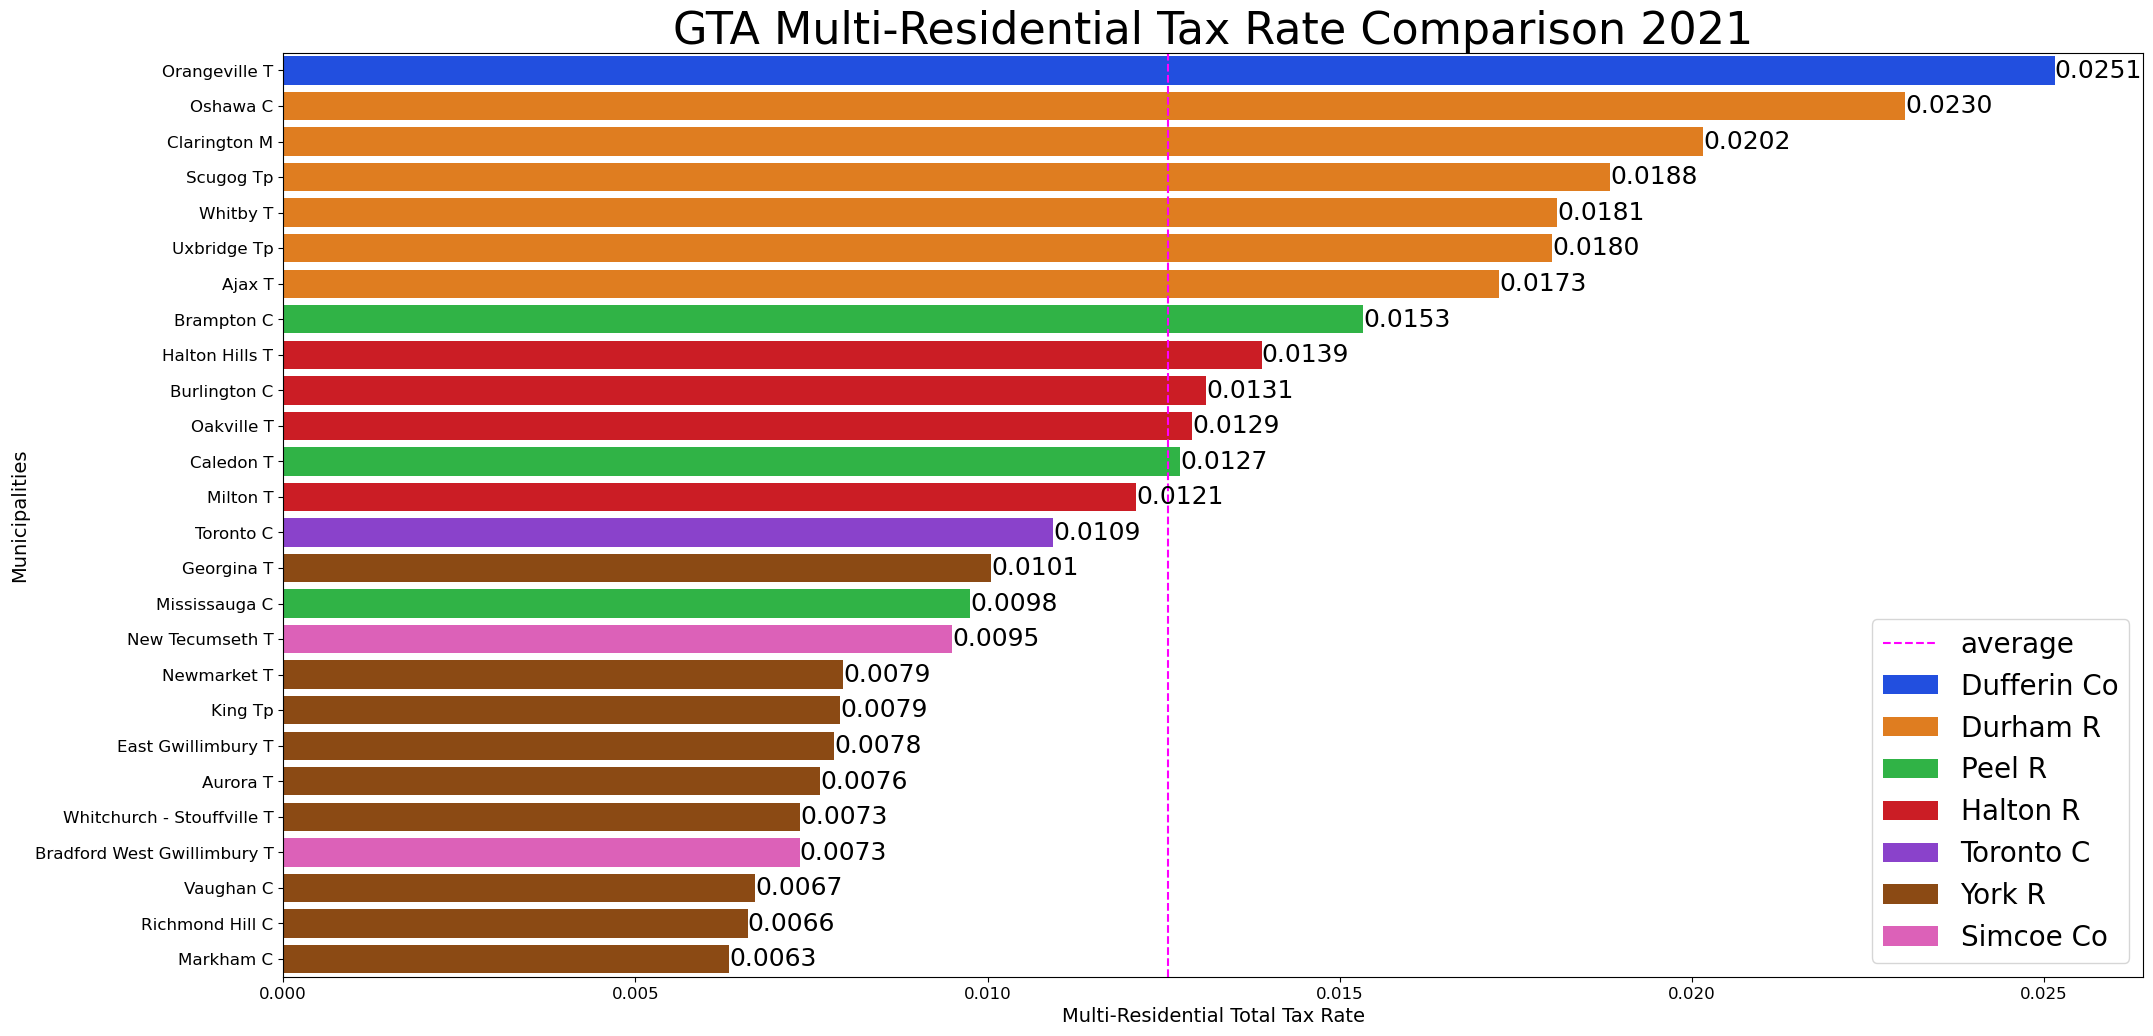

In [23]:
data=gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Multi-Residential'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Multi-Residential Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Multi-Residential Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

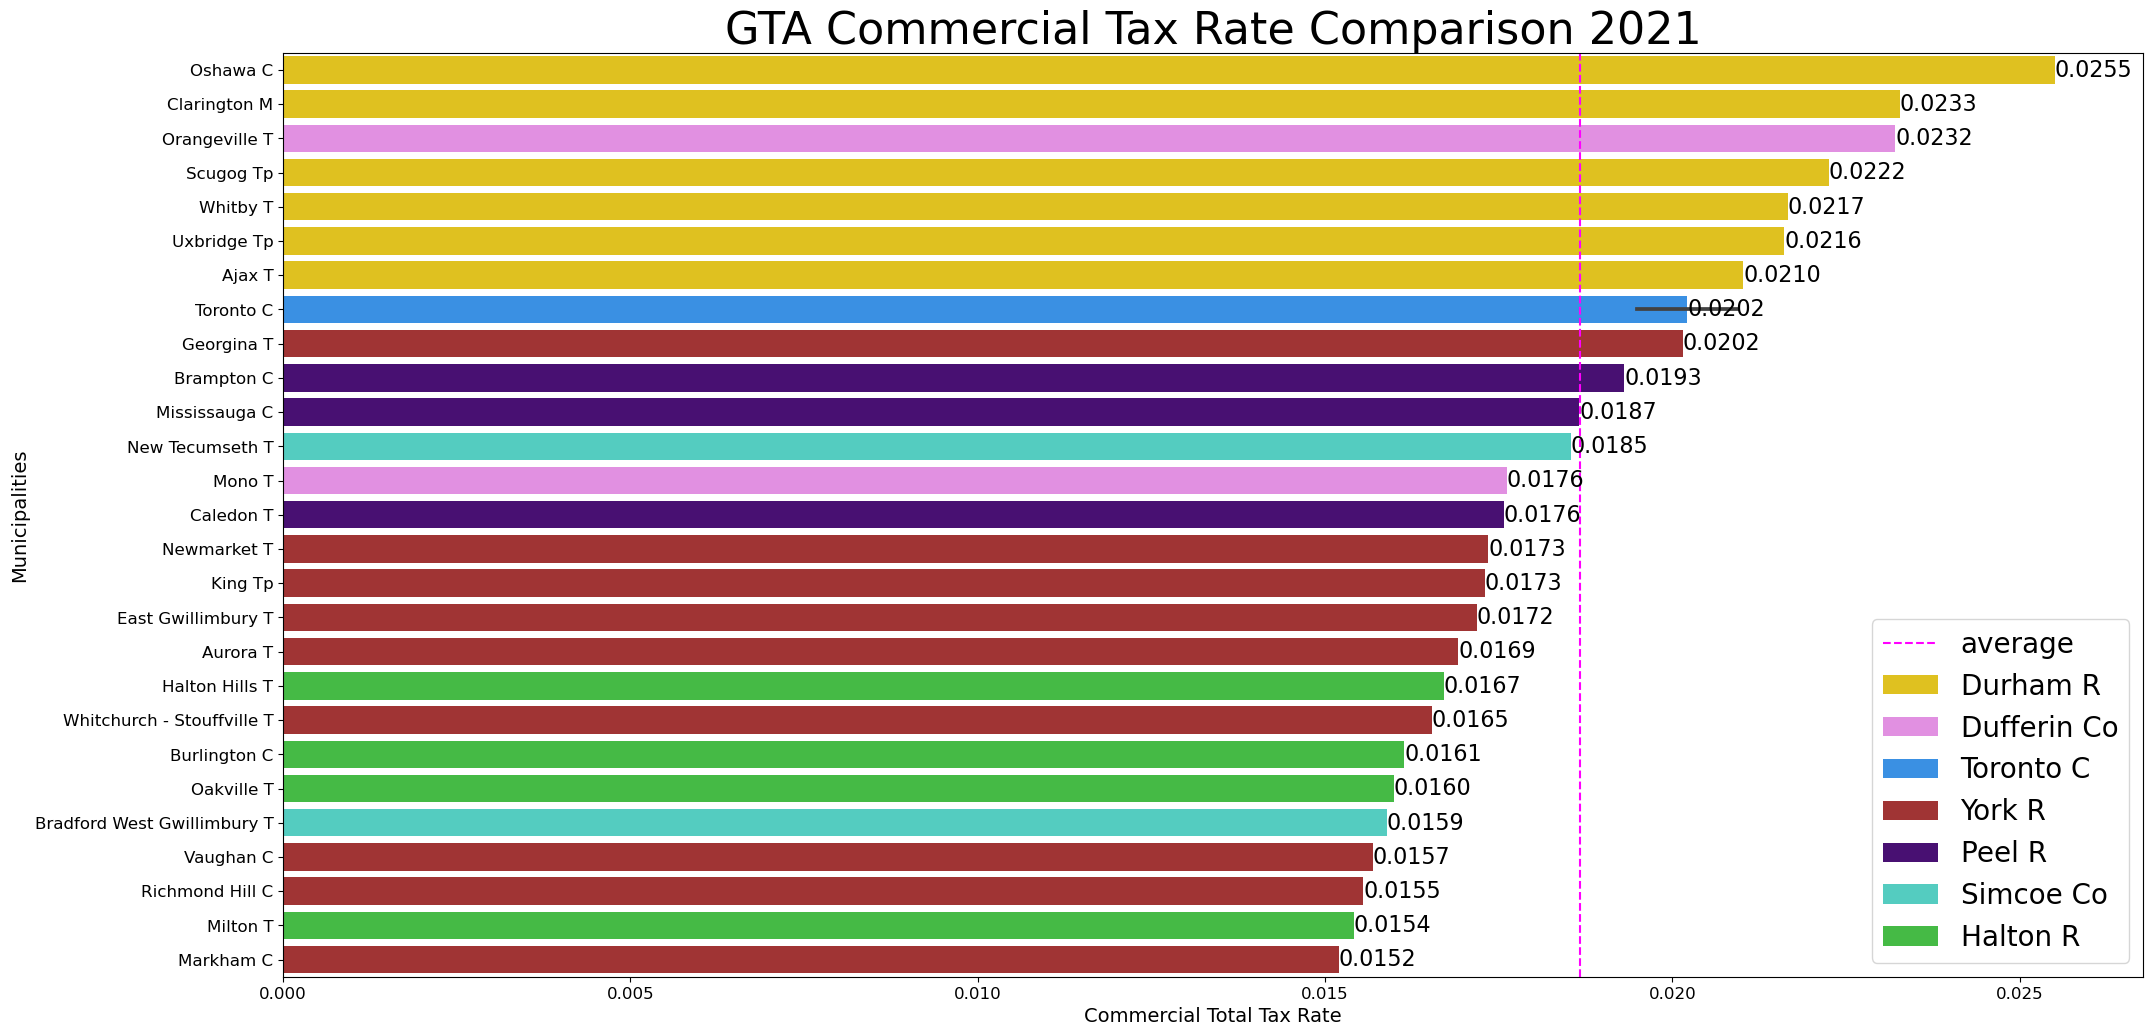

In [61]:
data=gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Commercial'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Commercial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Commercial Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

There is a slight irregularity in the chart above.  Notice the black error bar at the end of the bar representing Toronto's Commercial Rate.  This shows up because there are actually two commercial property class rates for Full Occupied properties.

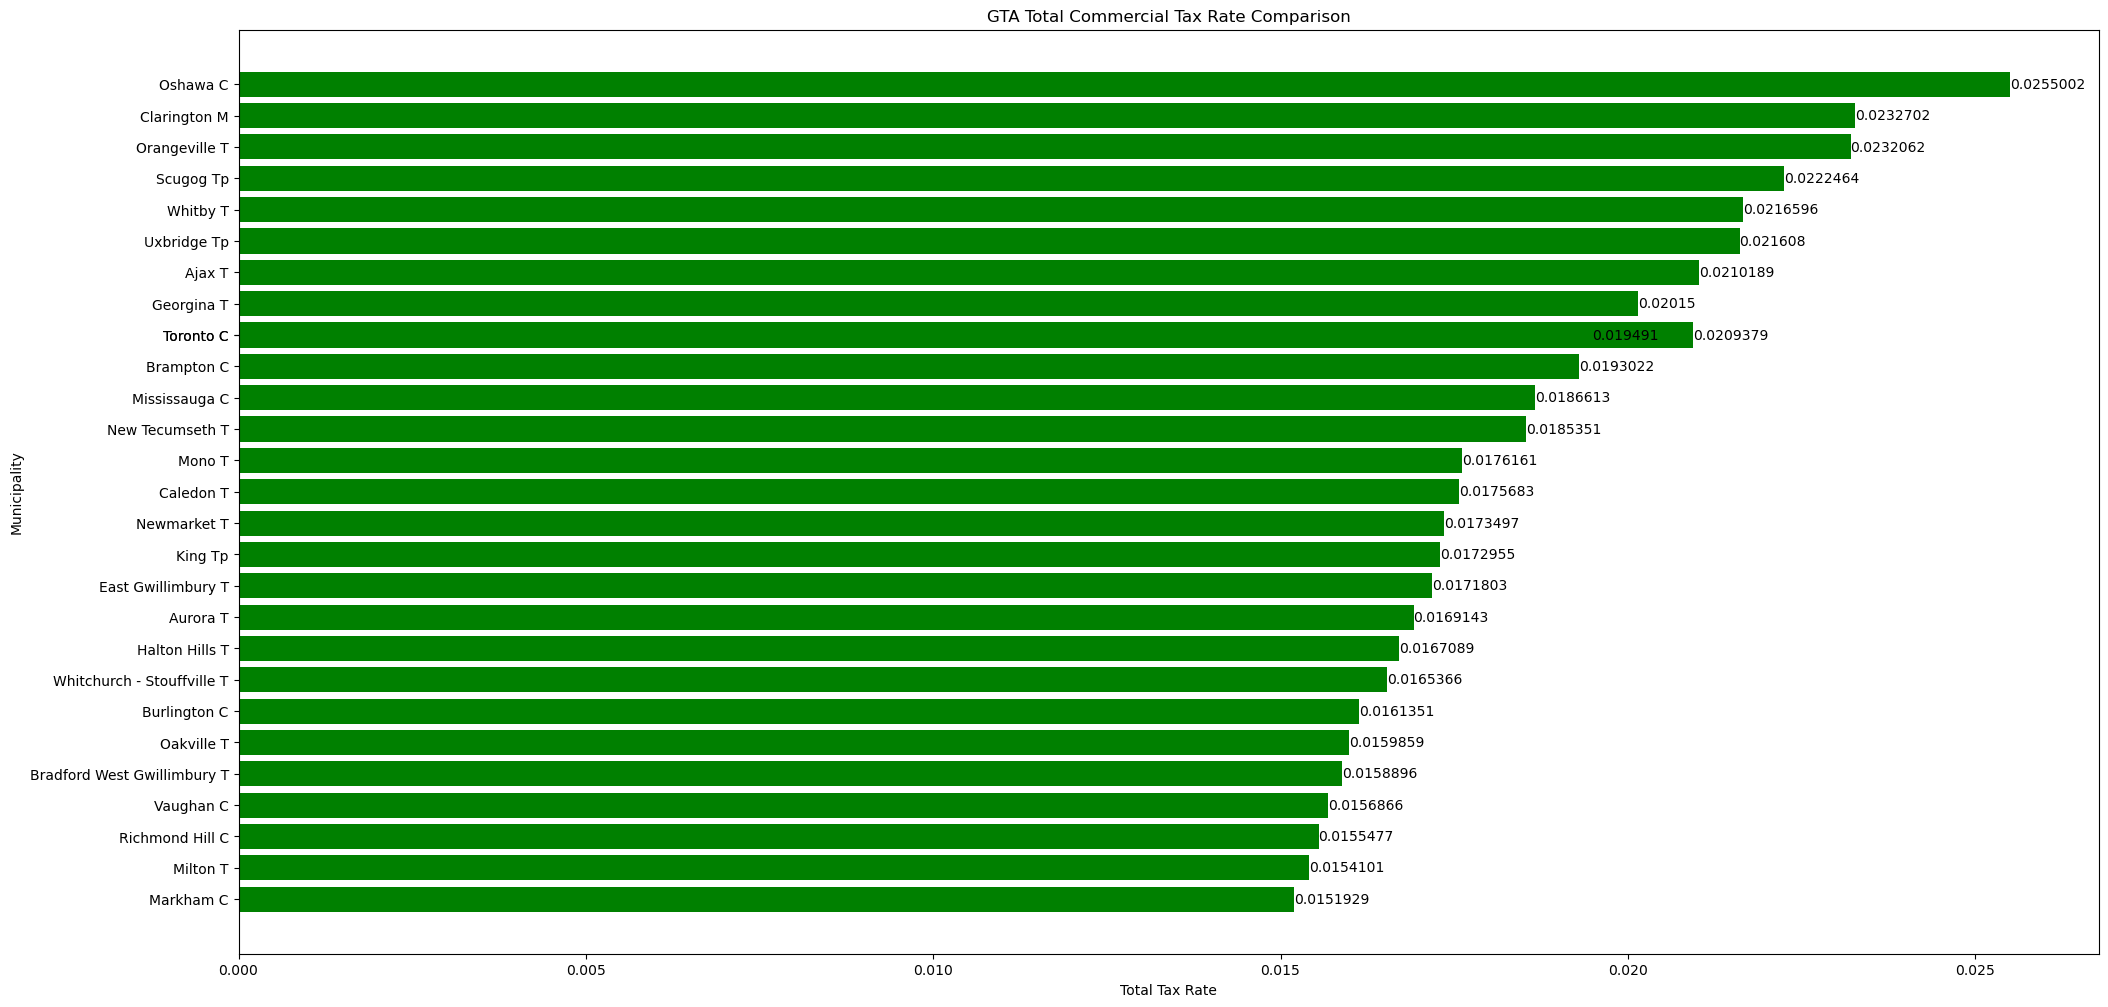

In [25]:
data = gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Commercial'].sort_values(by='Total_TaxRate')

fig,ax = plt.subplots(figsize=(24,12))
bars = ax.barh(data['Municipality'],data['Total_TaxRate'],align='center', color=['green'])
ax.set_yticks(data['Municipality'])
ax.set_xlabel('Total Tax Rate')
ax.set_ylabel('Municipality')
ax.set_title('GTA Total Commercial Tax Rate Comparison')
ax.bar_label(bars)
plt.show()

This chart clearly shows the two commercial tax rates for Toronto.

These two rates represent graduated taxation (banding).  With banding properties assessmented below a certain value threshold are taxed at a lower rate while all remaining properties are taxed at a higher level.  Banding represents redistribution within a revene class (i.e. revenue neutral). The higher tax on the upper band has to make up the revenue that is forgone by the lower rate on the lower band.

Very few municipalities use this method of graduated taxation (e.g. Orillia and Smith's Falls)

In [26]:
gta_ptax_frame[(gta_ptax_frame['Property Class'] == 'Commercial') & (gta_ptax_frame['Municipality'] == 'Toronto C')]

,Year,Asmt Code,Municipality,MAH Code,MunID,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,RTC/RTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,CVA Assessment,Phase-In Taxable Assessment,LtSt_TaxRate,Ut_Rate,Education_Rate,Total_TaxRate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update
7064,2021,1999,Toronto C,1106,20002,1,ST,11,211,0,Toronto C,CT,L,Commercial,Full Occupied,2.5743,1.0,2.035952e+10,2.035952e+10,0.011090,NaN,0.008401,0.019491,225784660,0,171042383,396827043,2022-09-29
7065,2021,1999,Toronto C,1106,20002,1,ST,11,213,0,Toronto C,CT,H,Commercial,Full Occupied,2.5743,1.0,3.496227e+10,3.496227e+10,0.011913,NaN,0.009025,0.020938,416510029,0,315526067,732036096,2022-09-29


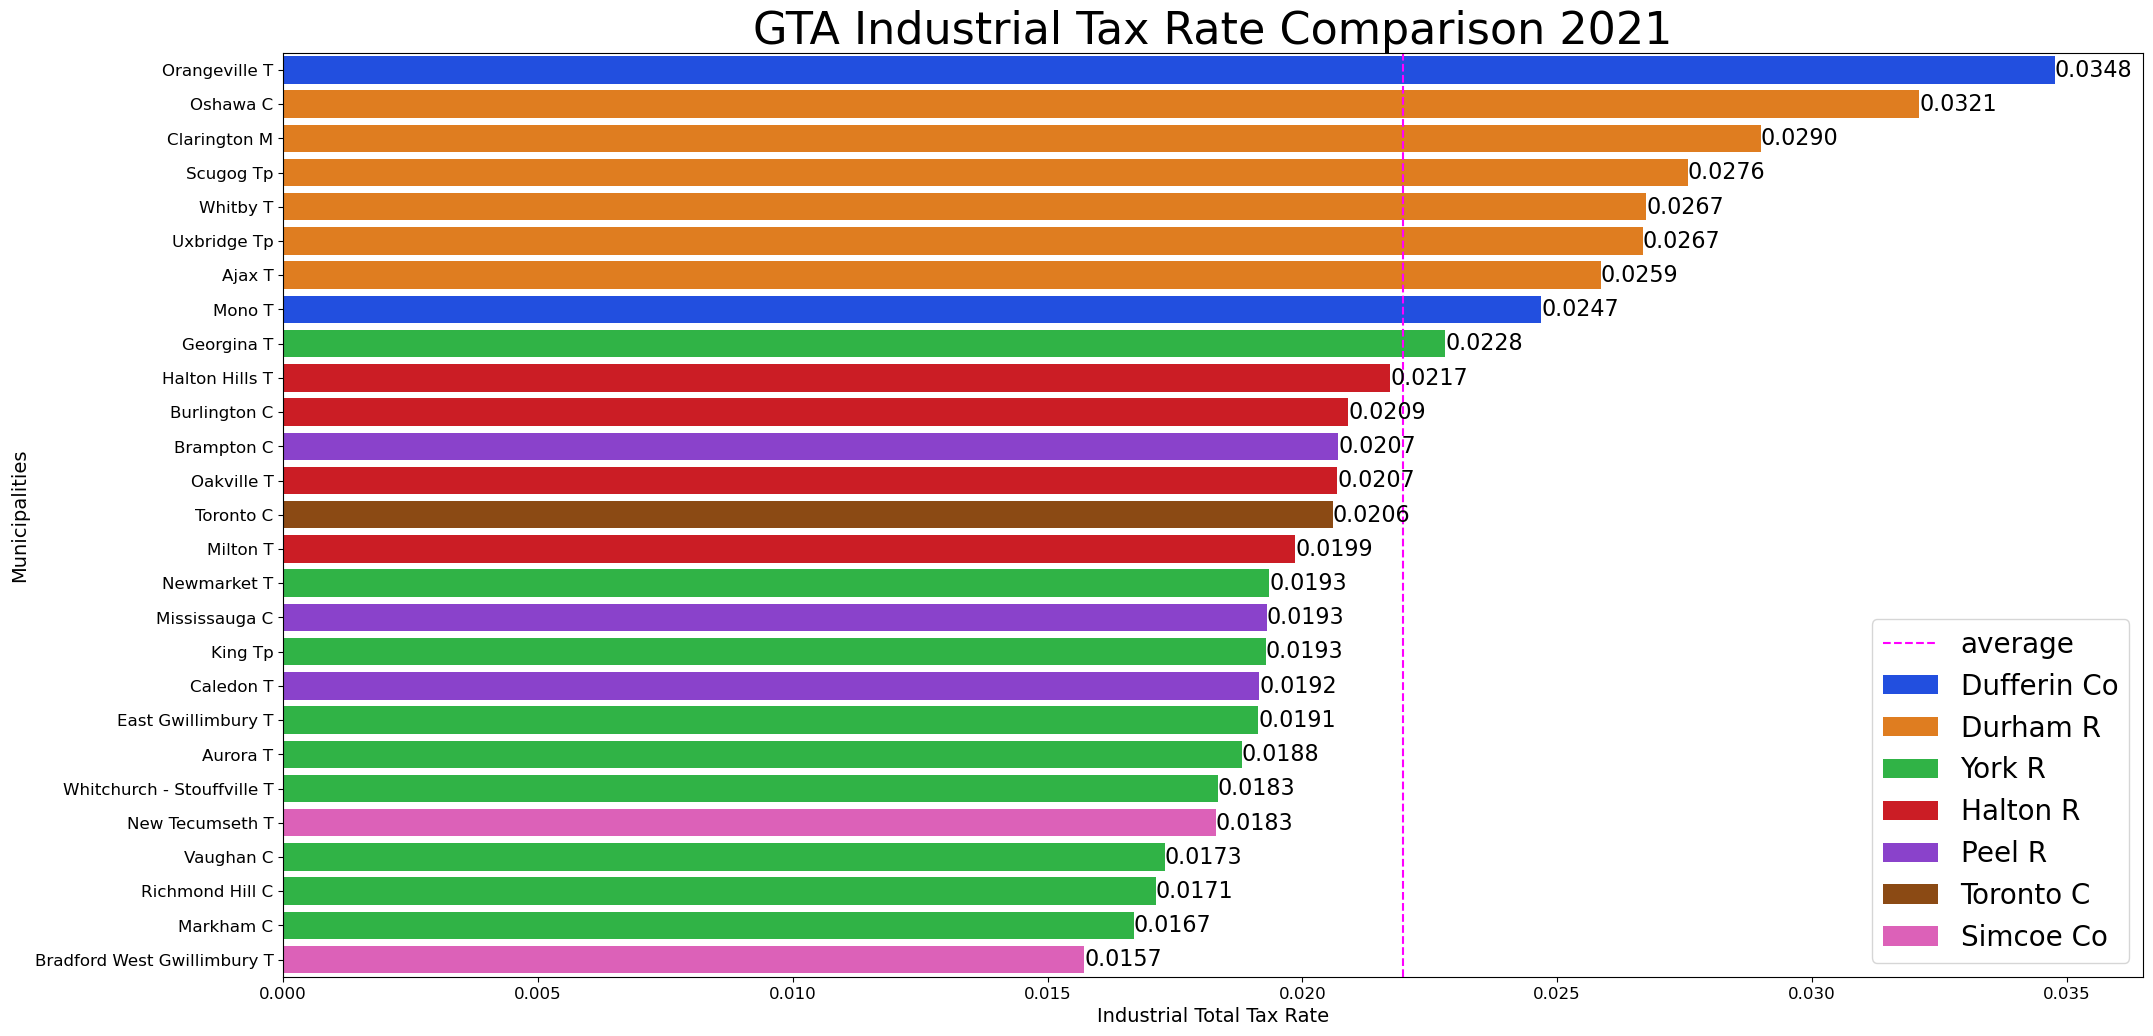

In [27]:
data=gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Industrial'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Industrial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Industrial Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

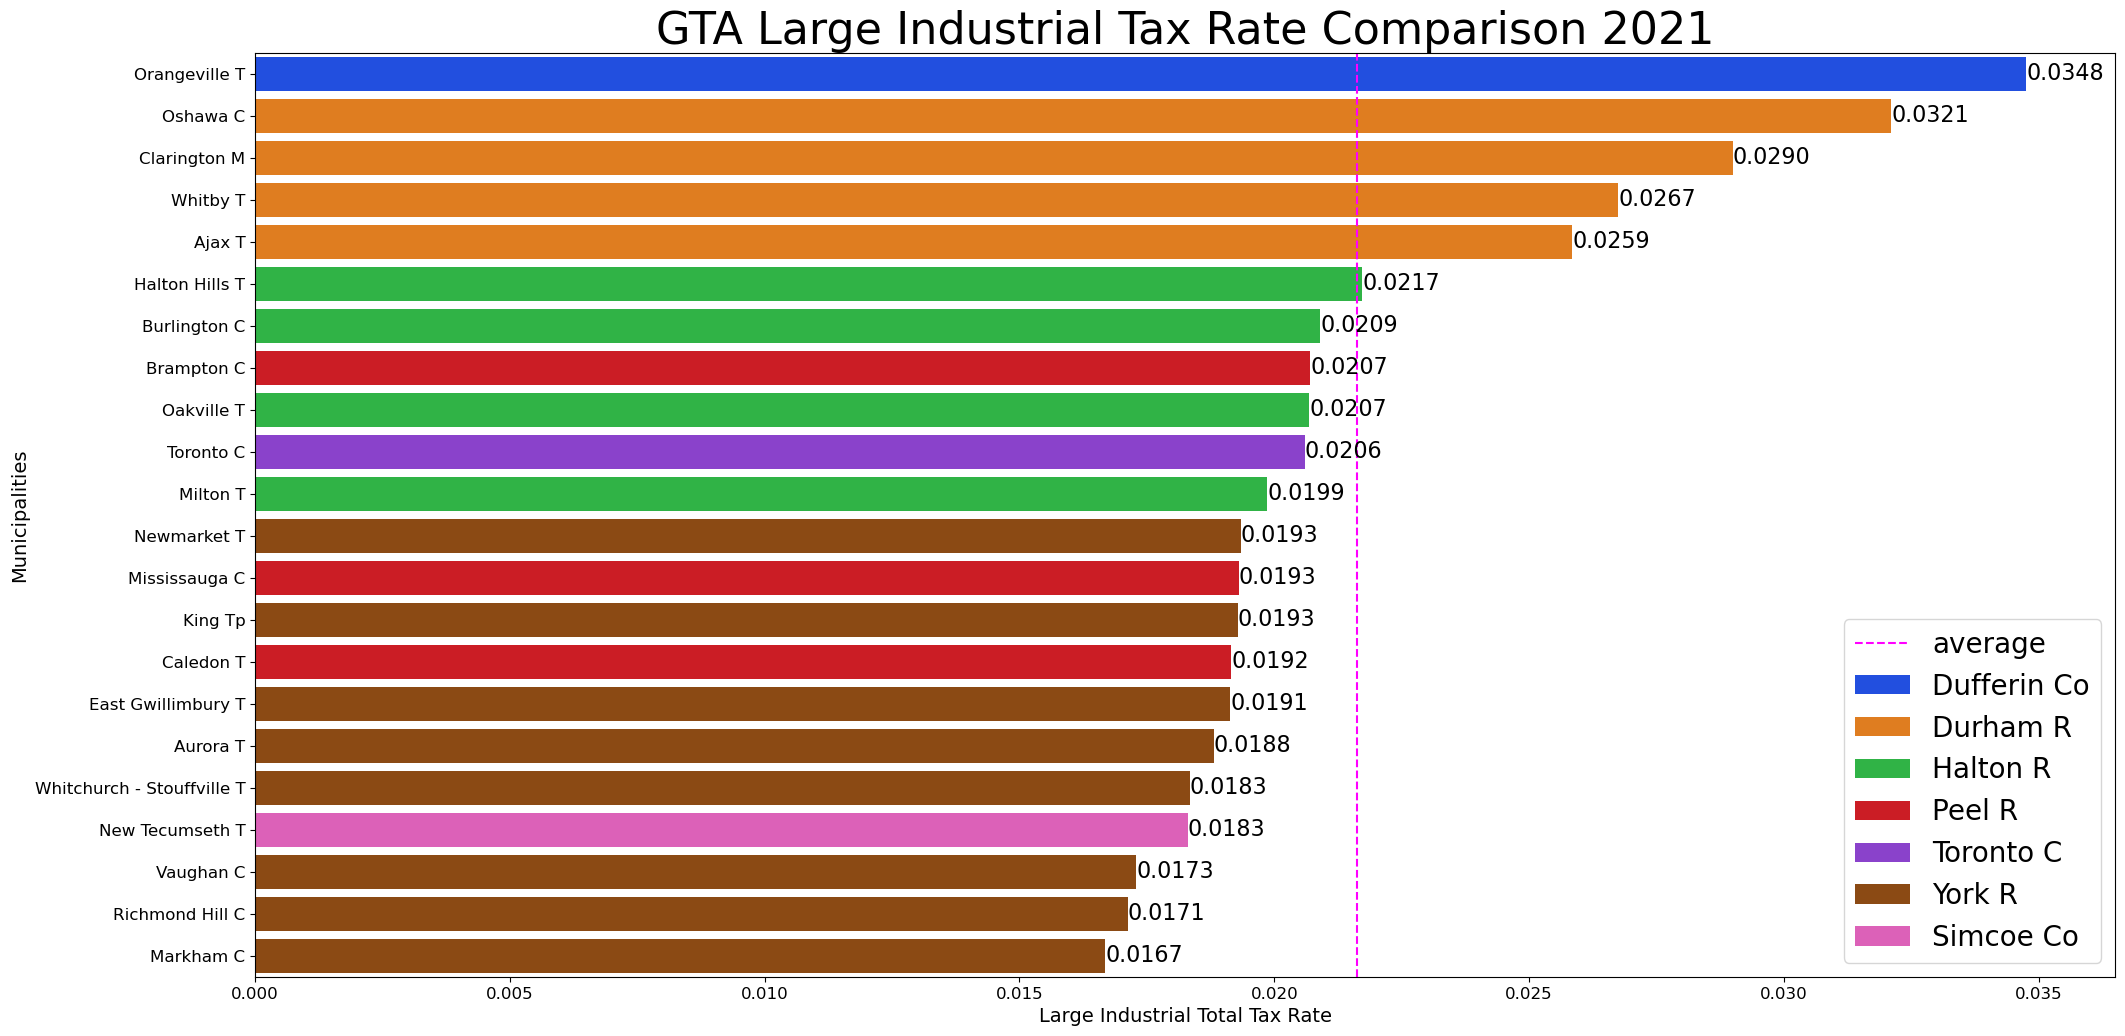

In [28]:
data=gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Large Industrial'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Large Industrial Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Large Industrial Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

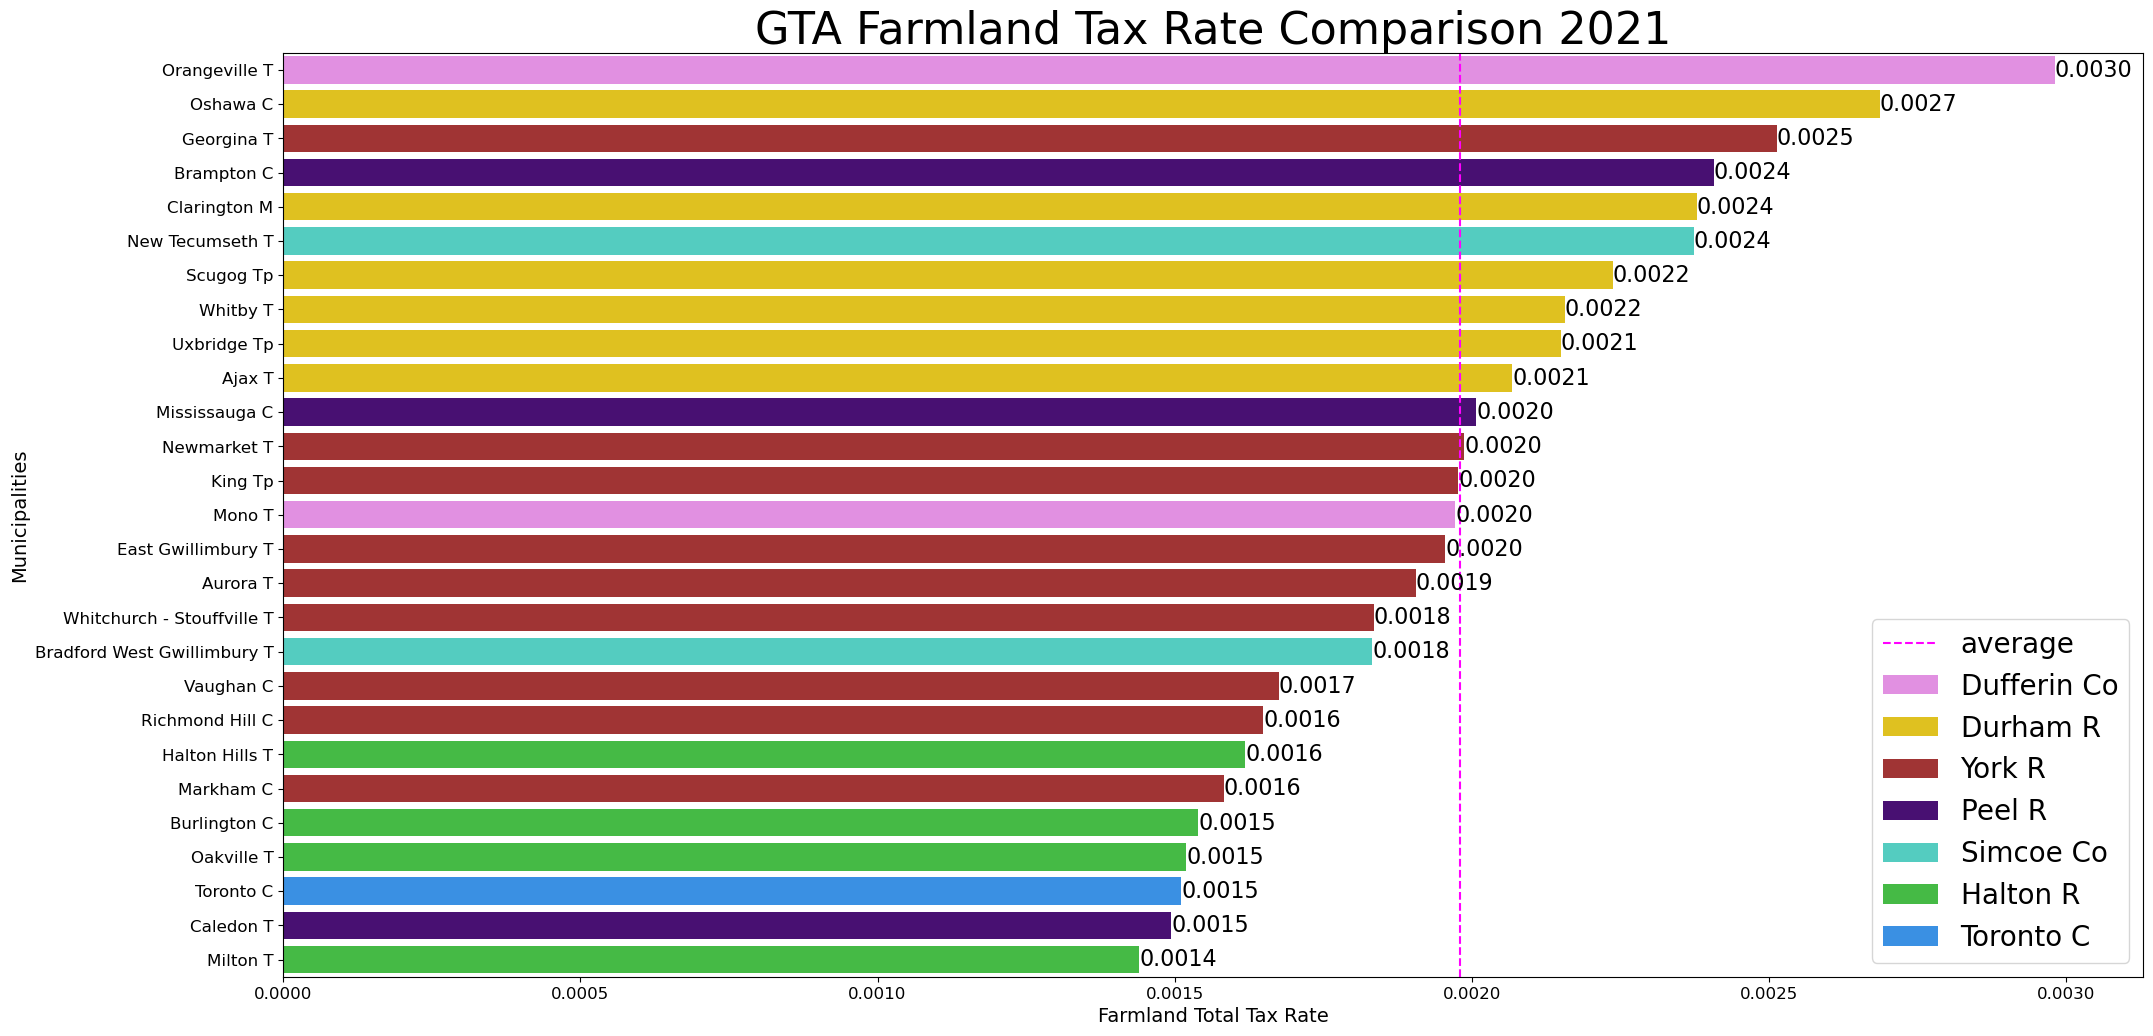

In [60]:
data=gta_sL_ptax[gta_sL_ptax['Property Class'] == 'Farmland'].sort_values(by='Total_TaxRate', ascending=False)

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data, y='Municipality', x='Total_TaxRate', orient='h', palette=palette, dodge=False, hue='Region')
ax.set_xlabel('Farmland Total Tax Rate', fontsize=14)
ax.set_ylabel('Municipalities', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_title('GTA Farmland Tax Rate Comparison 2021', fontsize=32)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=16)
plt.axvline(data['Total_TaxRate'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':20})
plt.show()

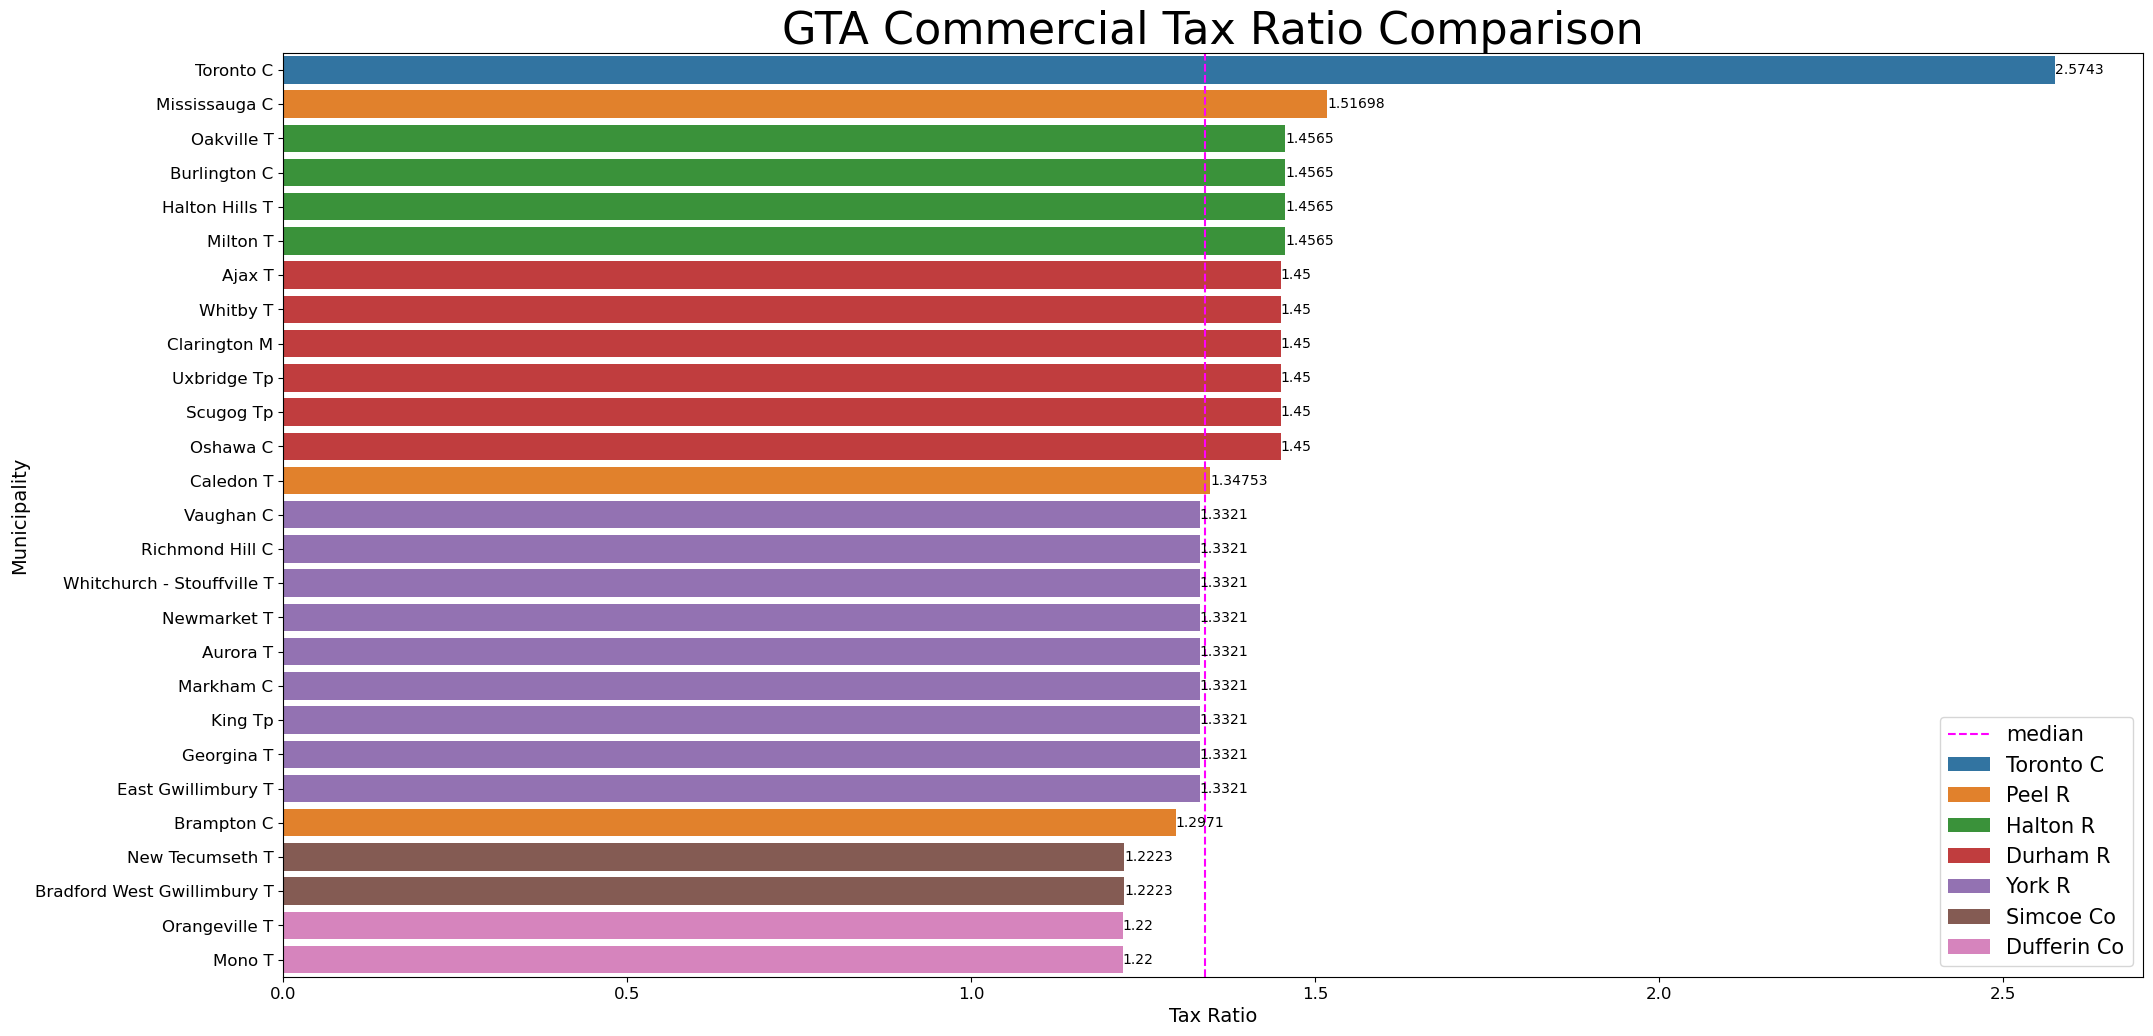

In [40]:
data = gta_sL_ptax[['Municipality', 'Property Class', 'Tax Ratio', 'Region']][gta_sL_ptax['Property Class'].isin(['Commercial'])]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data.sort_values(by='Tax Ratio', ascending=False), y='Municipality', x='Tax Ratio', hue='Region', orient='h', dodge=False)
ax.set_xlabel('Tax Ratio', fontsize=14)
ax.set_ylabel('Municipality', fontsize=14)
ax.set_title('GTA Commercial Tax Ratio Comparison', fontsize=32)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.axvline(data['Tax Ratio'].median(), color='magenta', linestyle='dashed', label='median')
plt.legend(loc='lower right', prop={'size':15})
plt.show()

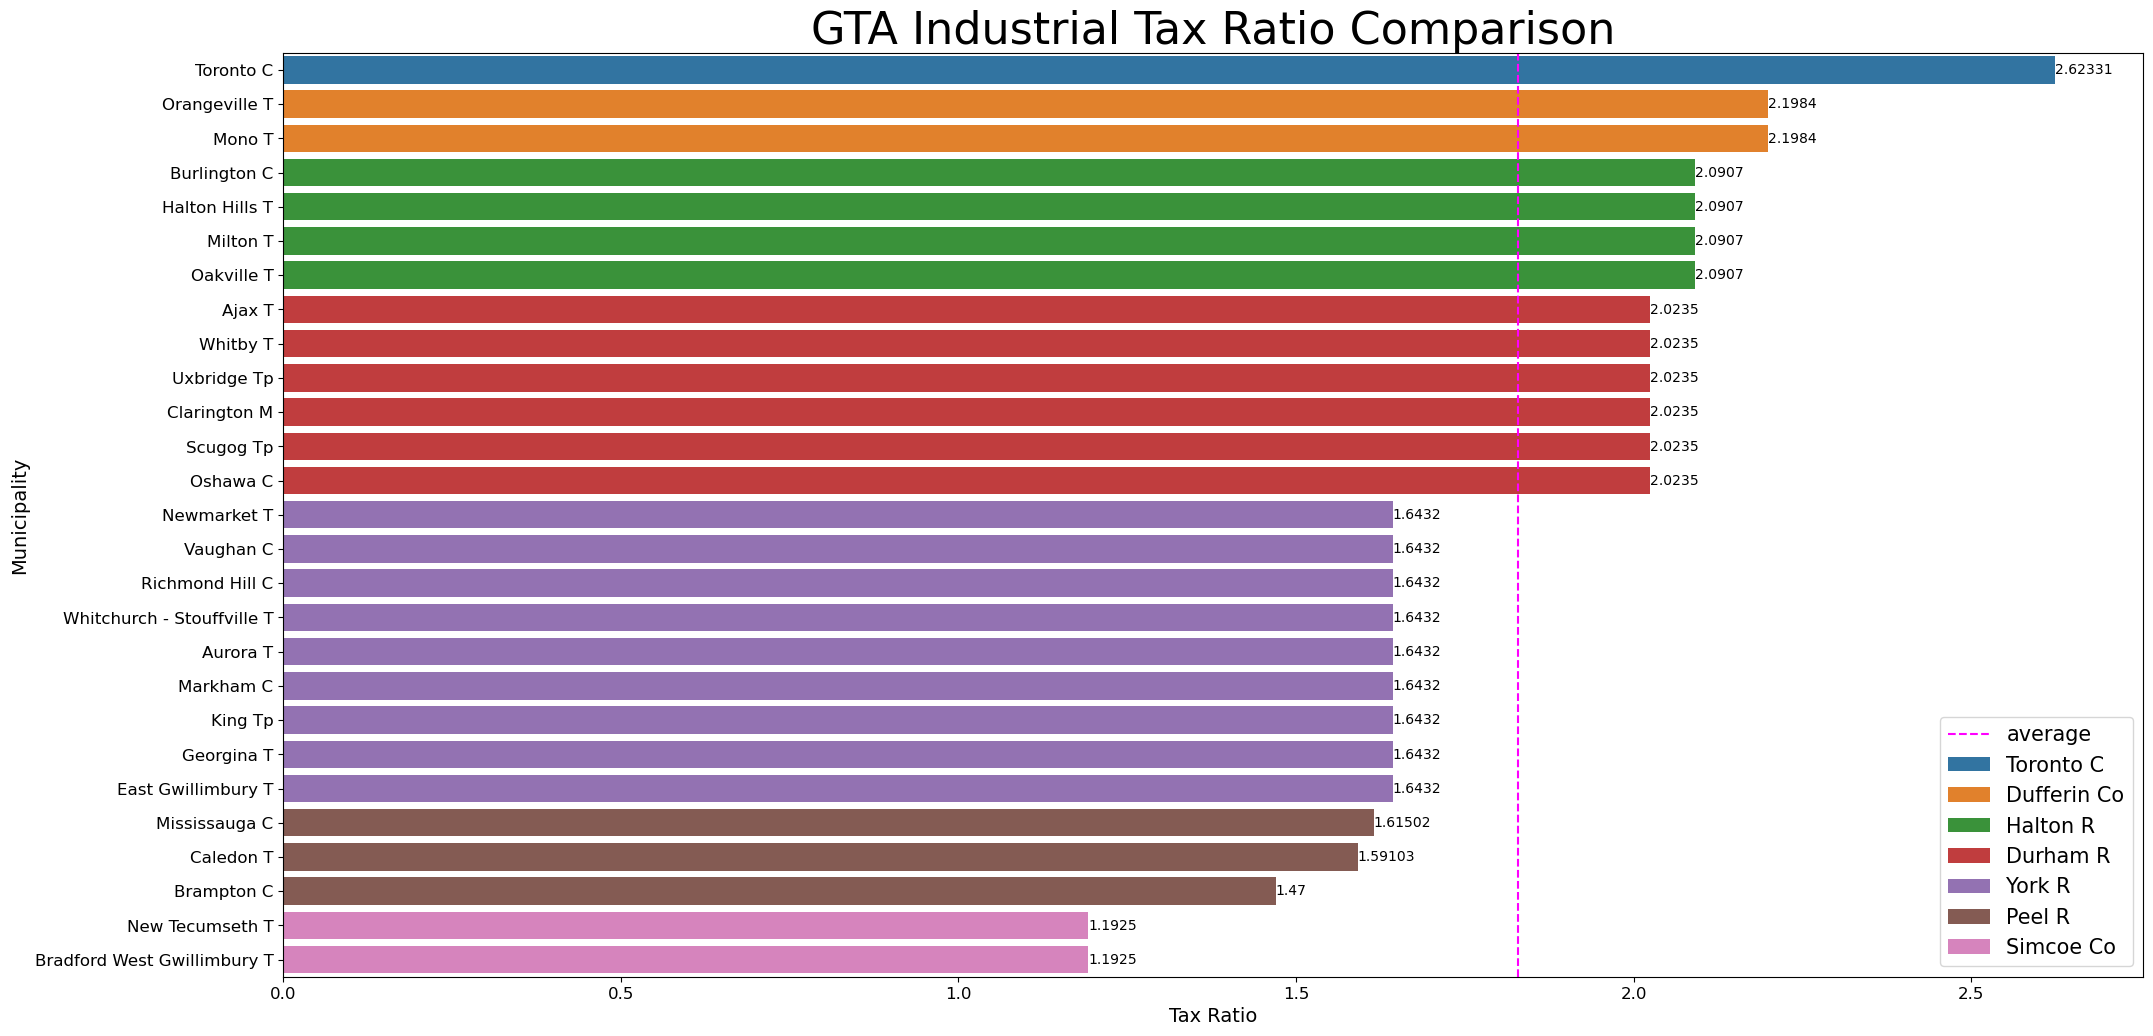

In [41]:
data = gta_sL_ptax[['Municipality', 'Property Class', 'Tax Ratio', 'Region']][gta_sL_ptax['Property Class'].isin(['Industrial'])]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data.sort_values(by='Tax Ratio', ascending=False), y='Municipality', x='Tax Ratio', hue='Region', orient='h', dodge=False)
ax.set_xlabel('Tax Ratio', fontsize=14)
ax.set_ylabel('Municipality', fontsize=14)
ax.set_title('GTA Industrial Tax Ratio Comparison', fontsize=32)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.axvline(data['Tax Ratio'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':15})
plt.show()

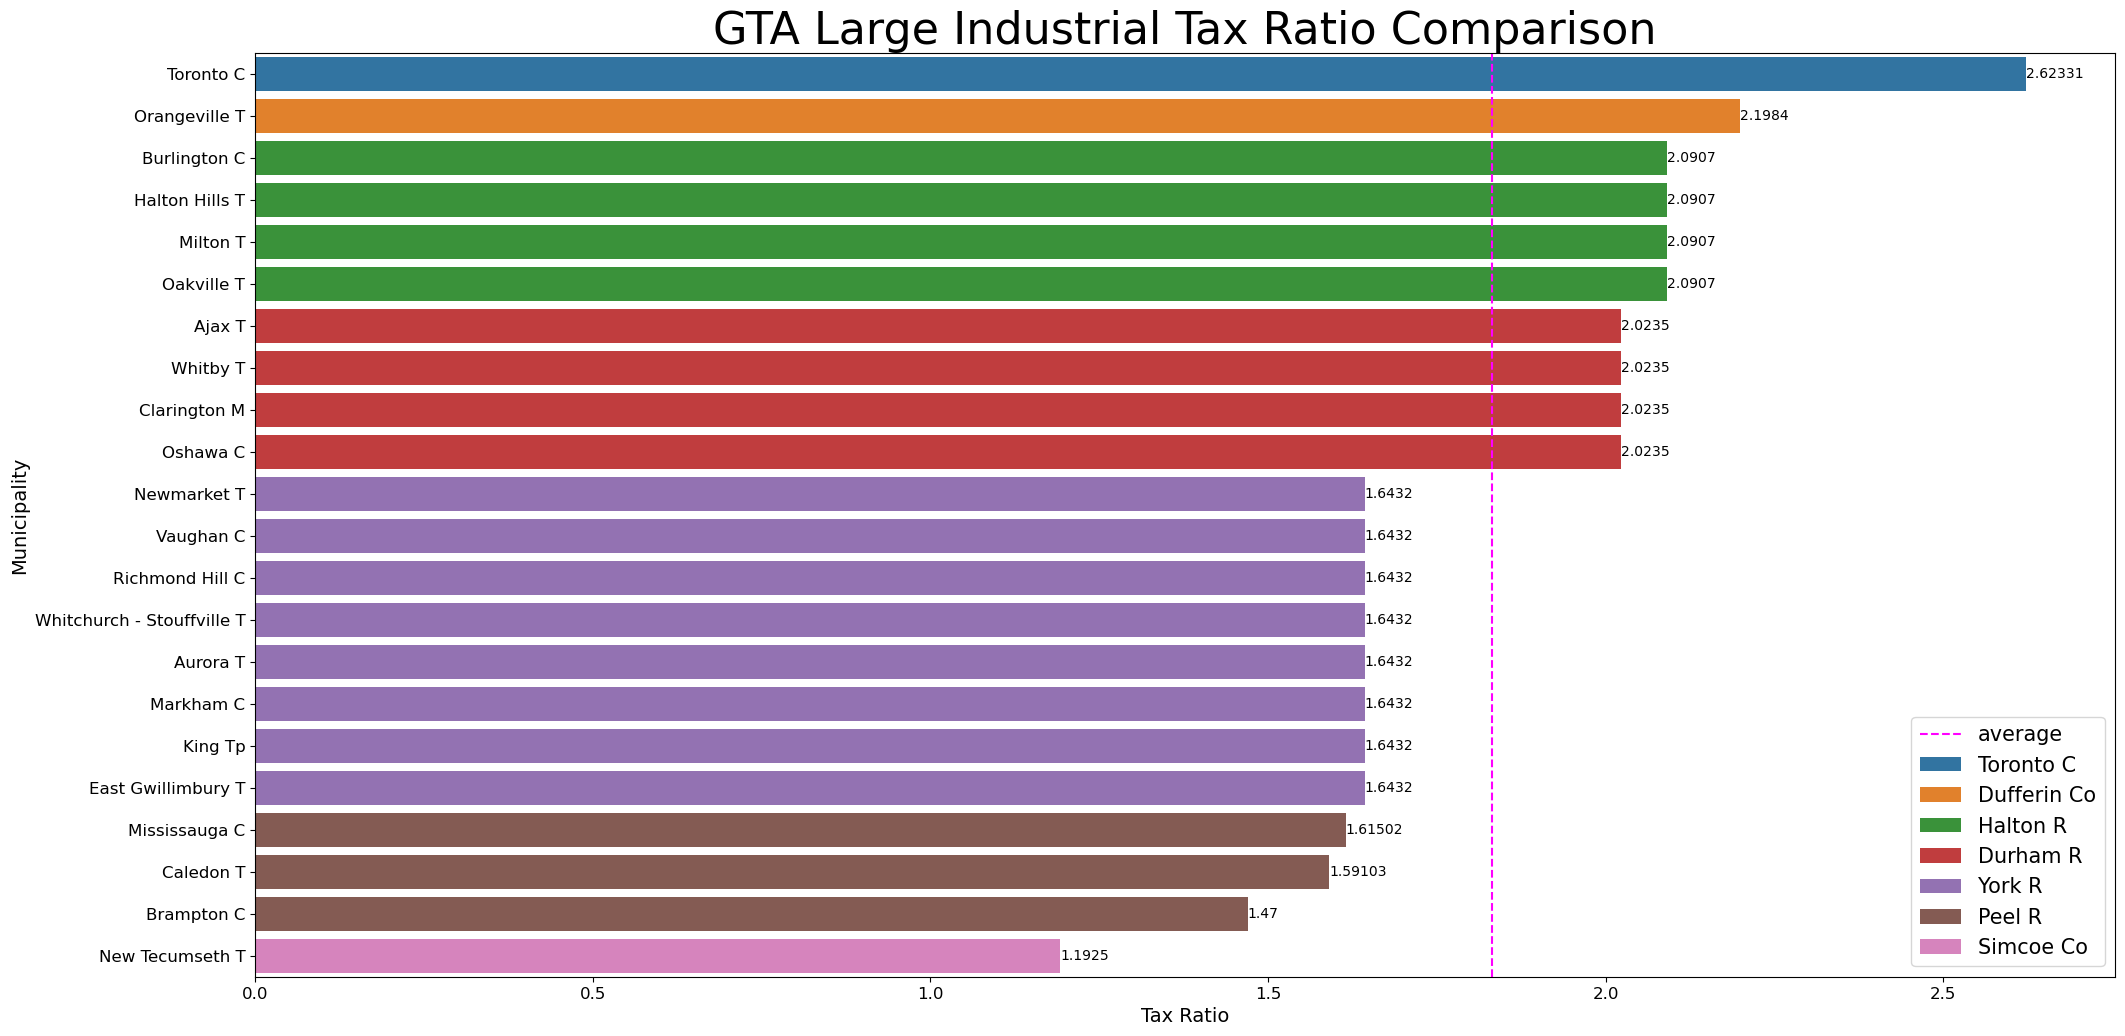

In [42]:
data = gta_sL_ptax[['Municipality', 'Property Class', 'Tax Ratio', 'Region']][gta_sL_ptax['Property Class'].isin(['Large Industrial'])]

fig, ax = plt.subplots(figsize=(24,12))
fig = sns.barplot(data=data.sort_values(by='Tax Ratio', ascending=False), y='Municipality', x='Tax Ratio', hue='Region', orient='h', dodge=False)
ax.set_xlabel('Tax Ratio', fontsize=14)
ax.set_ylabel('Municipality', fontsize=14)
ax.set_title('GTA Large Industrial Tax Ratio Comparison', fontsize=32)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
for container in ax.containers:
    ax.bar_label(container)
plt.axvline(data['Tax Ratio'].mean(), color='magenta', linestyle='dashed', label='average')
plt.legend(loc='lower right', prop={'size':15})
plt.show()